<p class='main_title'>Quantum Machine Learning</p>  
<hr>

Code extracted from [Itaú Data Science Meetup](https://www.youtube.com/watch?v=2XOfnq4niwQ)  

# Imports

In [1]:
# Dependencies
# !pip install pennylane
# !pip install PennyLane-SF  
# !pip install pennylane-qiskit
# !pip install qiskit
# !pip install pylatexenc

In [2]:
# Math op and data manipulation
import pandas as pd
from pennylane import numpy as np
# Classical ML
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Quantum ML
import pennylane as qml
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.express as px
# Control reproducibility
import random
# ML Utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import session_info
qml.about()
session_info.show()

Name: PennyLane
Version: 0.23.1
Summary: PennyLane is a Python quantum machine learning library by Xanadu Inc.
Home-page: https://github.com/XanaduAI/pennylane
Author: 
Author-email: 
License: Apache License 2.0
Location: /Users/baiochi/opt/anaconda3/lib/python3.9/site-packages
Requires: appdirs, autograd, autoray, cachetools, networkx, numpy, pennylane-lightning, retworkx, scipy, semantic-version, toml
Required-by: PennyLane-Lightning, PennyLane-qiskit, PennyLane-SF

Platform info:           macOS-10.15.7-x86_64-i386-64bit
Python version:          3.9.12
Numpy version:           1.21.5
Scipy version:           1.7.3
Installed devices:
- default.gaussian (PennyLane-0.23.1)
- default.mixed (PennyLane-0.23.1)
- default.qubit (PennyLane-0.23.1)
- default.qubit.autograd (PennyLane-0.23.1)
- default.qubit.jax (PennyLane-0.23.1)
- default.qubit.tf (PennyLane-0.23.1)
- default.qubit.torch (PennyLane-0.23.1)
- lightning.qubit (PennyLane-Lightning-0.23.0)
- qiskit.aer (PennyLane-qiskit-0.23.0)


In [3]:
# def plot_history(history):
    
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
    
#     epochs = range(len(loss))

def set_seeds():
    np.random.seed(42)
    tf.random.set_seed(42)
    random.seed(42)
    tf.keras.utils.set_random_seed(42)
    tf.config.experimental.enable_op_determinism()

# Variational Quantum Classifier

Network with 3 layers:  
- **Feature map** $U_{\phi(x)}$: code classical data into quantum state which will be processed in the quantum circuit by the algorithm;
- **Variational layer** $W(\vec{\theta})$: contains the data parametrized by $\vec{\theta}$ used in the training process;
- **Measurement**: qubits measures, output in classic information.  

Hybrid method:  
- Foward propagation: quantum
- Recover classical information and calculate the cost function
- Perform backpropagation in the classical method

# Example with Iris data

## Loading and Preprocessing dataset

In [4]:
df = sns.load_dataset('iris')                          # Load data
X = df.drop(columns='species').astype('float32')       # Select features
y = df['species']                                      # Select target
X_train, X_test, y_train, y_test = train_test_split(   # Train-test split
    X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_eval, y_train, y_eval = train_test_split(   # Train-eval split
    X_train, y_train, test_size=0.3, stratify=y_train, 
    random_state=42)
y_train_n = y_train.astype('category').cat.codes       # Encode labels
y_eval_n  =  y_eval.astype('category').cat.codes
y_test_n  =  y_test.astype('category').cat.codes
y_train_tf = tf.one_hot(y_train_n, depth=y_train_n.nunique()) # Create tensors(one-hot encode labels)
y_eval_tf  = tf.one_hot(y_eval_n,  depth=y_eval_n.nunique())

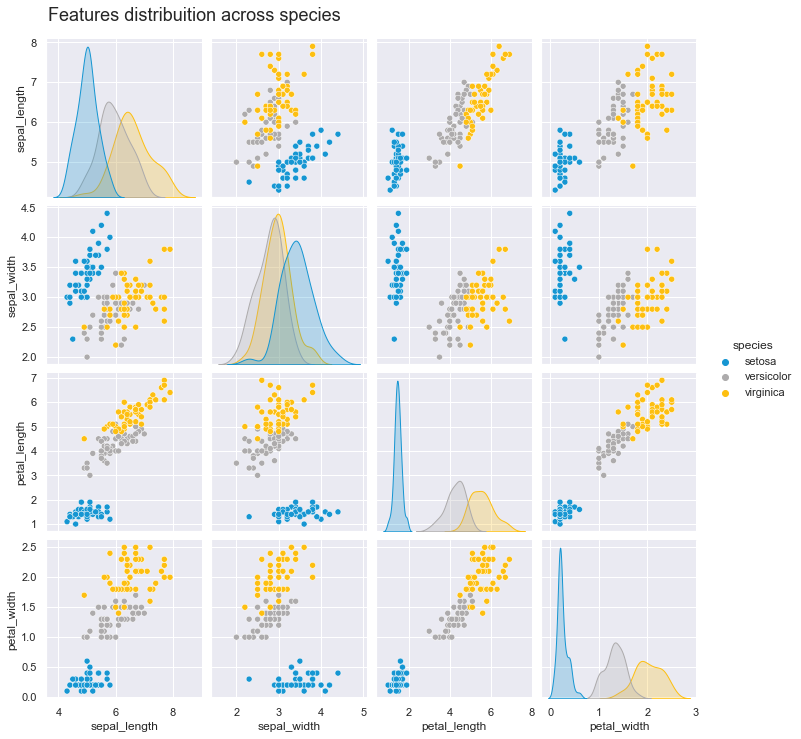

In [5]:
sns.pairplot(df, hue='species', palette=['#1696D2','#adabac','#fdbf11'],
).fig.suptitle('Features distribuition across species', size=18, x=0.25, y=1.025);

## Building the architecture

In [6]:
n_qubits = X_train.shape[1]

dev = qml.device('default.qubit', wires=n_qubits)

dev_qiskit = qml.device('qiskit.aer', wires=n_qubits, seed_simulatior=42)

## Feature map

[-0.08007812 -0.7890625   0.98828125 -0.40429688]


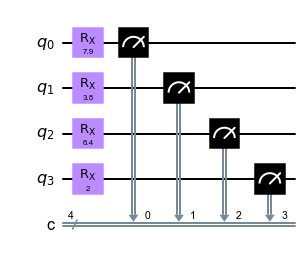

In [7]:
@qml.qnode(dev_qiskit)
def fm(inputs):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

print(fm(X_train.iloc[0].values))
dev_qiskit._circuit.draw('mpl')

In [8]:
X_train.iloc[0]

sepal_length    7.9
sepal_width     3.8
petal_length    6.4
petal_width     2.0
Name: 131, dtype: float32

## Variational layer

[0.62304688 0.578125   0.37695312 0.37695312]


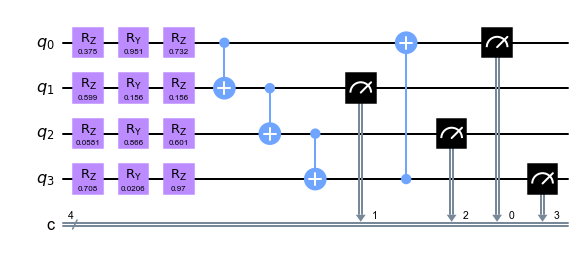

In [9]:
@qml.qnode(dev_qiskit)
def var_layer(weights):
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=4)
np.random.seed(42)
weights = np.random.random(size=shape)

print(var_layer(weights))
dev_qiskit._circuit.draw('mpl')

In [10]:
weights

tensor([[[0.37454012, 0.95071431, 0.73199394],
         [0.59865848, 0.15601864, 0.15599452],
         [0.05808361, 0.86617615, 0.60111501],
         [0.70807258, 0.02058449, 0.96990985]]], requires_grad=True)

## Training model

In [11]:
set_seeds()
# Define shapes
n_qubits = X_train.shape[1]
n_classes = y_train.nunique()
n_var_layers = 2
weight_shapes = {'weights': (n_var_layers, n_qubits, 3)}
# Quantum circuit
@qml.qnode(dev_qiskit)
def vqc_layer(inputs, weights):
    # Feature map
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    # Variational layer
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_classes)]
# Build Neural Network
model = keras.models.Sequential()
model.add(qml.qnn.KerasLayer(vqc_layer, weight_shapes, output_dim=n_classes))
model.add(layers.Activation('softmax'))
opt = keras.optimizers.Adam(learning_rate=0.05)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
# Fit model
history = model.fit(
    X_train, y_train_tf,
    epochs=10, batch_size=10,
    validation_data=(X_eval, y_eval_tf)
)

Epoch 1/10
